# Basic Spatial Anlysis with Python

## Overview
In this lecture, we will investigate the differences between Euclidean distance and Manhattan distance and between Buffer and Convex Hull. To exemplify, we will examine the census block group that is accessible to healthcare resources (i.e., hospitals, emergency medical services, and urgent care) in Champaign County. 

## Data
* Census block group: https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=Block+Groups
* Healthcare resources: 
    * Hospitals: https://hifld-geoplatform.opendata.arcgis.com/maps/hospitals/about
    * Emergency Medical Service (EMS) Stations: https://hifld-geoplatform.opendata.arcgis.com/datasets/geoplatform::emergency-medical-service-ems-stations/about
    * Urgent Care Facilities: https://hifld-geoplatform.opendata.arcgis.com/datasets/geoplatform::urgent-care-facilities/about

## Glance the difference
### Euclidean distance (4058 feet) vs Manhattan distance (1.2 Miles; 6336 feet)
<img src="./data/euclidean_vs_manhattan.jpg" style="width: 600px;"/>

### Buffer vs Convex Hull

## 1. Data Preparation

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Healthcare resources
hc = gpd.read_file('./data/healthcare.shp')
hc.head()

,NAME,TYPE,geometry
0,THE CARLE FOUNDATION HOSPITAL,Hospital,POINT (-88.21495 40.11704)
1,THE PAVILION FOUNDATION,Hospital,POINT (-88.25754 40.11771)
2,OSF HEALTHCARE SYSTEM HEART OF MARY MEDICAL CE...,Hospital,POINT (-88.22711 40.11797)
3,URBANA FIRE RESCUE SERVICES - MAIN STATION,EMS,POINT (-88.20452 40.10999)
4,SAVOY FIRE DEPARTMENT,EMS,POINT (-88.25114 40.06293)


In [3]:
# Census block groups
cbg = gpd.read_file('./data/census_block_group.shp')
cbg.head()

,STATEFP,COUNTYFP,GEOID,geometry
0,17,019,170190008004,"POLYGON ((-88.25812 40.15652, -88.25810 40.156..."
1,17,019,170190109021,"POLYGON ((-88.31384 40.04801, -88.31383 40.048..."
2,17,019,170190014003,"POLYGON ((-88.24917 40.06616, -88.24917 40.066..."
3,17,019,170190008003,"POLYGON ((-88.27710 40.15771, -88.27705 40.157..."
4,17,019,170190109023,"POLYGON ((-88.46265 39.96709, -88.46203 39.967..."


Let's examine the geographical distribution of healthcare resources and census block groups. 
For detail information, Visit `Week6/Geospatial_Data_Visualization.ipynb`. <br>
**Note**: We can specify the order of layers with `zorder` attribute. Higher `zorder` will place the layer on top. 

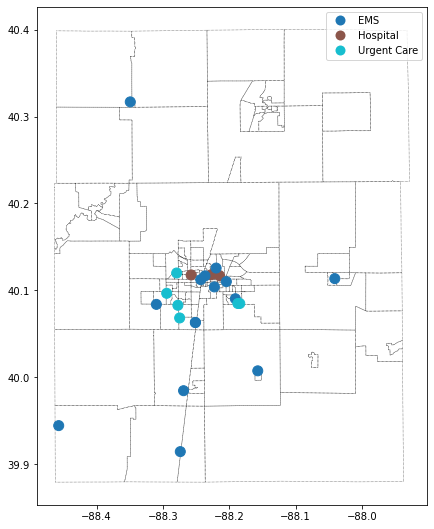

In [4]:
# Plot two layers
fig, ax = plt.subplots(figsize=(7, 10))

hc.plot(ax=ax, column='TYPE', markersize=100, legend=True, zorder=2)
cbg.boundary.plot(ax=ax, linestyle='dotted', lw=0.5, color='black', zorder=1)

plt.show()

You will find that the units (or coordinates) of the maps are decimal degrees (longitude and latitude). As we want to measure the distance between census block groups and healthcare resources, we need to reproject two GeoDataFrame (`hc` and `cbg`) from a geographical coordinate system (NAD83; EPSG 4269) to a projected coordinates system (SPCS83 Illinois East zone (meters); EPSG 26971). 

In [5]:
hc.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [6]:
hc = hc.to_crs(epsg=26971)
cbg = cbg.to_crs(epsg=26971)
hc.crs

<Derived Projected CRS: EPSG:26971>
Name: NAD83 / Illinois East
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Illinois - counties of Boone; Champaign; Clark; Clay; Coles; Cook; Crawford; Cumberland; De Kalb; De Witt; Douglas; Du Page; Edgar; Edwards; Effingham; Fayette; Ford; Franklin; Gallatin; Grundy; Hamilton; Hardin; Iroquois; Jasper; Jefferson; Johnson; Kane; Kankakee; Kendall; La Salle; Lake; Lawrence; Livingston; Macon; Marion; Massac; McHenry; McLean; Moultrie; Piatt; Pope; Richland; Saline; Shelby; Vermilion; Wabash; Wayne; White; Will; Williamson.
- bounds: (-89.28, 37.06, -87.02, 42.5)
Coordinate Operation:
- name: SPCS83 Illinois East zone (meters)
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## 2. Simple Buffer Analysis

First of all, let's determine how far we can travel within a given time. Here, we assume that **10 minutes** is the threshold travel time and **30 MPH** is the travel speed in the study area. Therefore, the travel distance is 5 Miles. 

\begin{gather*}
Distance = Speed * Time\\
\\
5Miles = 30MPH * \frac{10 minutes} {60 minutes}
\end{gather*}

In [7]:
travel_time = 10
dist = 30 * travel_time / 60

# Translate to Meter per Hour to match the unit with the coordinates system (epsg 26971)
dist = dist * 1.6 * 1000
dist
print(f'{dist} meter is the threshold distance can travel within {travel_time} minutes.')

8000.0 meter is the threshold distance can travel within 10 minutes.


Several ways of doing buffer, but all have the same result. 

In [8]:
# Call buffer from GeoDataFrame
hc_buffer = hc.buffer(dist)
print(type(hc_buffer))
hc_buffer

<class 'geopandas.geoseries.GeoSeries'>


0     POLYGON ((318091.878 383002.829, 318053.356 38...
1     POLYGON ((314461.377 383072.805, 314422.855 38...
2     POLYGON ((317055.291 383104.709, 317016.769 38...
3     POLYGON ((318981.581 382221.278, 318943.059 38...
4     POLYGON ((315012.101 376990.985, 314973.579 37...
5     POLYGON ((297427.513 363812.027, 297388.991 36...
6     POLYGON ((315011.685 376991.399, 314973.163 37...
7     POLYGON ((323037.769 370824.924, 322999.247 37...
8     POLYGON ((317667.772 383956.074, 317629.249 38...
9     POLYGON ((306647.051 405198.482, 306608.529 40...
10    POLYGON ((313082.427 360481.503, 313043.904 35...
11    POLYGON ((332905.397 382639.591, 332866.875 38...
12    POLYGON ((316244.612 382955.738, 316206.090 38...
13    POLYGON ((317445.679 381543.077, 317407.157 38...
14    POLYGON ((309996.706 379305.380, 309958.184 37...
15    POLYGON ((315693.003 382469.623, 315654.481 38...
16    POLYGON ((313495.975 368272.002, 313457.453 36...
17    POLYGON ((320142.619 380036.351, 320104.09

In [9]:
# Call Buffer from GeoSeires (has to be geometry column)
hc_buffer = hc.geometry.buffer(dist)
hc_buffer

0     POLYGON ((318091.878 383002.829, 318053.356 38...
1     POLYGON ((314461.377 383072.805, 314422.855 38...
2     POLYGON ((317055.291 383104.709, 317016.769 38...
3     POLYGON ((318981.581 382221.278, 318943.059 38...
4     POLYGON ((315012.101 376990.985, 314973.579 37...
5     POLYGON ((297427.513 363812.027, 297388.991 36...
6     POLYGON ((315011.685 376991.399, 314973.163 37...
7     POLYGON ((323037.769 370824.924, 322999.247 37...
8     POLYGON ((317667.772 383956.074, 317629.249 38...
9     POLYGON ((306647.051 405198.482, 306608.529 40...
10    POLYGON ((313082.427 360481.503, 313043.904 35...
11    POLYGON ((332905.397 382639.591, 332866.875 38...
12    POLYGON ((316244.612 382955.738, 316206.090 38...
13    POLYGON ((317445.679 381543.077, 317407.157 38...
14    POLYGON ((309996.706 379305.380, 309958.184 37...
15    POLYGON ((315693.003 382469.623, 315654.481 38...
16    POLYGON ((313495.975 368272.002, 313457.453 36...
17    POLYGON ((320142.619 380036.351, 320104.09

In [10]:
# Iterate through the GeoDataFrame and call buffer
for idx, row in hc.iterrows():
    print(row['geometry'].buffer(dist))

POLYGON ((318091.87816100905 383002.829220243, 318053.3559743866 382218.6920976065, 317938.1604042349 381442.10664411396, 317747.4008468667 380680.55180220725, 317482.91442109935 379941.36176132225, 317147.2482757959 379231.655325635, 316743.6350594294 378558.2673560862, 316275.96178791096 377927.6829469338, 315748.73241050146 377345.97497075057, 315167.02443431824 376818.74559334107, 314536.44002516585 376351.07232182263, 313863.05205561704 375947.45910545613, 313153.3456199298 375611.79296015267, 312414.1555790448 375347.3065343853, 311652.60073713807 375156.54697701713, 310876.01528364554 375041.3514068654, 310091.87816100905 375002.829220243, 309307.74103837257 375041.3514068654, 308531.15558488003 375156.54697701713, 307769.6007429733 375347.3065343853, 307030.4107020883 375611.79296015267, 306320.70426640107 375947.45910545613, 305647.31629685225 376351.07232182263, 305016.73188769986 376818.74559334107, 304435.02391151665 377345.97497075057, 303907.79453410715 377927.6829469338,

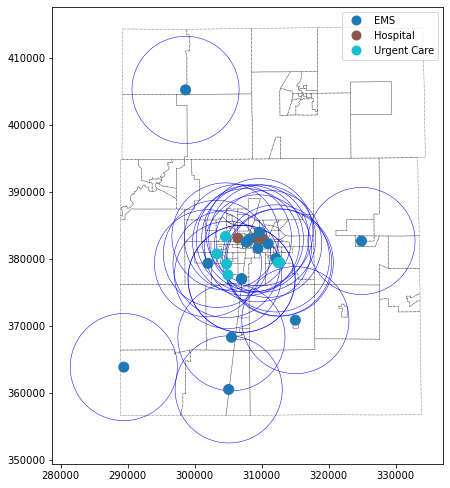

In [11]:
# Plot two layers
fig, ax = plt.subplots(figsize=(7, 10))

hc_buffer.boundary.plot(ax=ax, color='blue', lw=0.5, zorder=1)
hc.plot(ax=ax, column='TYPE', markersize=100, legend=True, zorder=2)
cbg.boundary.plot(ax=ax, linestyle='dotted', lw=0.5, color='black', zorder=1)

plt.show()

Given that the type of `hc_buffer` is `GeoSeries` (not `GeoDataFrame`), you can iterate the rows with `GeoSeries.iteritems()`.

In [12]:
for idx, buf in hc_buffer.iteritems():
    print(buf)

POLYGON ((318091.87816100905 383002.829220243, 318053.3559743866 382218.6920976065, 317938.1604042349 381442.10664411396, 317747.4008468667 380680.55180220725, 317482.91442109935 379941.36176132225, 317147.2482757959 379231.655325635, 316743.6350594294 378558.2673560862, 316275.96178791096 377927.6829469338, 315748.73241050146 377345.97497075057, 315167.02443431824 376818.74559334107, 314536.44002516585 376351.07232182263, 313863.05205561704 375947.45910545613, 313153.3456199298 375611.79296015267, 312414.1555790448 375347.3065343853, 311652.60073713807 375156.54697701713, 310876.01528364554 375041.3514068654, 310091.87816100905 375002.829220243, 309307.74103837257 375041.3514068654, 308531.15558488003 375156.54697701713, 307769.6007429733 375347.3065343853, 307030.4107020883 375611.79296015267, 306320.70426640107 375947.45910545613, 305647.31629685225 376351.07232182263, 305016.73188769986 376818.74559334107, 304435.02391151665 377345.97497075057, 303907.79453410715 377927.6829469338,

In [13]:
# The following code will not run. 
# for idx, buf in hc_buffer.iterrows():
#     print(buf)

You may remember that you can slice a `GeoDataFrame` with the function below. Let's see how we can select the census block group within each buffer.  
```python
cbg.loc[cbg.geometry.within()]
```

In [14]:
cbg.loc[cbg.geometry.within(buf)]

,STATEFP,COUNTYFP,GEOID,geometry
2,17,019,170190014003,"POLYGON ((307179.741 377349.506, 307179.910 37..."
10,17,019,170190109015,"POLYGON ((306460.396 371143.798, 306489.735 37..."
12,17,019,170190009014,"POLYGON ((304804.515 384150.781, 305076.325 38..."
15,17,019,170190013023,"POLYGON ((304881.864 377591.621, 304881.966 37..."
17,17,019,170190059021,"POLYGON ((308902.125 382520.506, 308910.053 38..."
...,...,...,...,...
153,17,019,170190010001,"POLYGON ((304302.691 382601.330, 304303.966 38..."
154,17,019,170190011002,"POLYGON ((305636.634 382099.221, 305732.205 38..."
155,17,019,170190011001,"POLYGON ((304831.133 382104.327, 304932.333 38..."
156,17,019,170190012011,"POLYGON ((304040.692 381369.153, 304050.924 38..."


In [15]:
within_cbg = []
for idx, buf in hc_buffer.iteritems():
    temp_gdf = cbg.loc[cbg.geometry.within(buf)]
    within_cbg.extend(temp_gdf['GEOID'].to_list())
    
within_cbg

['170190008004',
 '170190014003',
 '170190008003',
 '170190009014',
 '170190008002',
 '170190059021',
 '170190054011',
 '170190110013',
 '170190056011',
 '170190059011',
 '170190056012',
 '170190056021',
 '170190056015',
 '170190059022',
 '170190056013',
 '170190056014',
 '170190053002',
 '170190009013',
 '170190110012',
 '170190110021',
 '170190110011',
 '170190003013',
 '170190110022',
 '170190003022',
 '170190014001',
 '170190004012',
 '170190012015',
 '170190004022',
 '170190053001',
 '170190054021',
 '170190012013',
 '170190003023',
 '170190054023',
 '170190010004',
 '170190011003',
 '170190055003',
 '170190057014',
 '170190058004',
 '170190054013',
 '170190053004',
 '170190111001',
 '170190058001',
 '170190058005',
 '170190060001',
 '170190060002',
 '170190111002',
 '170190013015',
 '170190058003',
 '170190005003',
 '170190009012',
 '170190003012',
 '170190054012',
 '170190003011',
 '170190002002',
 '170190010002',
 '170190058002',
 '170190002001',
 '170190003021',
 '170190004011

You will notice that the resulted list `within_cbg` is larger than the entire number of census block groups (`cbg`). This is because of duplicates, and `set()` will help you to select only the unique values. 

In [16]:
len(within_cbg)

1540

In [17]:
len(cbg)

158

In [18]:
len(set(within_cbg))

115

Now, we will select the census block groups only within the buffers. Let's use `.loc[]` method to provide our result. <br>
**Note** You can reverse the result by adding `~` in front of the condition.  

In [19]:
cbg.loc[cbg['GEOID'].isin(set(within_cbg))]

,STATEFP,COUNTYFP,GEOID,geometry
0,17,019,170190008004,"POLYGON ((306407.568 387381.633, 306409.506 38..."
2,17,019,170190014003,"POLYGON ((307179.741 377349.506, 307179.910 37..."
3,17,019,170190008003,"POLYGON ((304790.796 387513.235, 304795.054 38..."
7,17,019,170190056022,"POLYGON ((312959.265 380709.613, 312959.681 38..."
9,17,019,170190009023,"POLYGON ((298501.876 385793.938, 298529.400 38..."
...,...,...,...,...
153,17,019,170190010001,"POLYGON ((304302.691 382601.330, 304303.966 38..."
154,17,019,170190011002,"POLYGON ((305636.634 382099.221, 305732.205 38..."
155,17,019,170190011001,"POLYGON ((304831.133 382104.327, 304932.333 38..."
156,17,019,170190012011,"POLYGON ((304040.692 381369.153, 304050.924 38..."


In [20]:
cbg.loc[~cbg['GEOID'].isin(set(within_cbg))]

,STATEFP,COUNTYFP,GEOID,geometry
1,17,019,170190109021,"POLYGON ((301663.744 375331.378, 301664.492 37..."
4,17,019,170190109023,"POLYGON ((288952.382 366354.051, 289005.181 36..."
5,17,019,170190109022,"POLYGON ((288934.725 376118.484, 288971.586 37..."
6,17,019,170190106034,"POLYGON ((288928.268 386475.420, 288982.045 38..."
8,17,019,170190107024,"POLYGON ((317702.422 394957.748, 318080.997 39..."
13,17,019,170190109012,"POLYGON ((308108.961 376042.803, 308294.454 37..."
19,17,019,170190107021,"POLYGON ((326766.968 386659.430, 326935.680 38..."
24,17,019,170190107022,"POLYGON ((328899.667 378591.290, 328899.654 37..."
33,17,019,170190109024,"POLYGON ((297915.653 356685.018, 297940.834 35..."
46,17,019,170190106012,"POLYGON ((293289.059 391362.401, 293297.097 39..."


In [21]:
y_buffer = cbg.loc[cbg['GEOID'].isin(set(within_cbg))]
n_buffer = cbg.loc[~cbg['GEOID'].isin(set(within_cbg))]

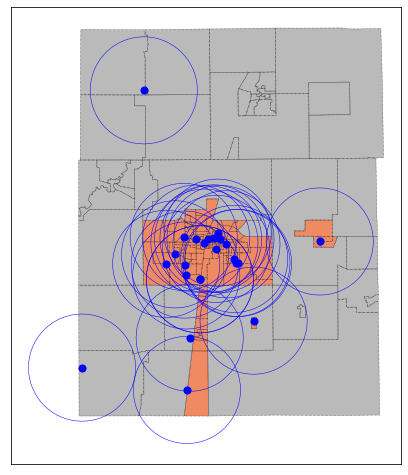

In [22]:
# Plot two layers
fig, ax = plt.subplots(figsize=(7, 10))

hc_buffer.boundary.plot(ax=ax, color='blue', lw=0.5, zorder=2)
y_buffer.plot(ax=ax, color='#ef8a62', zorder=1)
n_buffer.plot(ax=ax, color='#bababa', zorder=1)

hc.plot(ax=ax, markersize=50, color='blue', zorder=2)
cbg.boundary.plot(ax=ax, linestyle='dotted', lw=0.5, color='black', zorder=1)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

You may think having a large number of buffer make the map complicated and want to dissolve/union the buffer. You can use `.unary_union` for this purpose. 
**Note** The result of `unary_union` has the type of `Shapely`. You need to convert it back to `GeoSeries` or `GeoDataFrame` for plotting. 

<class 'shapely.geometry.multipolygon.MultiPolygon'>


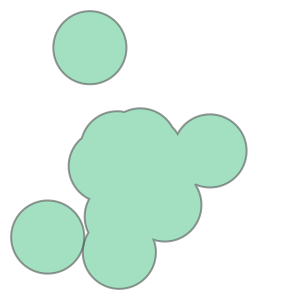

In [23]:
hc_buffer_union = hc.geometry.buffer(dist).unary_union
print(type(hc_buffer_union))
# hc_buffer.plot()   # Will cause a problem. Shapely does not have a method .plot()
hc_buffer_union

<class 'geopandas.geoseries.GeoSeries'>


<AxesSubplot:>

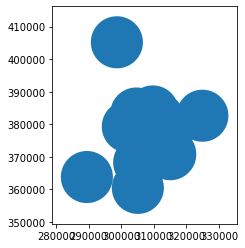

In [24]:
hc_buffer_union = gpd.GeoSeries(hc_buffer_union)
print(type(hc_buffer_union))
hc_buffer_union.plot()

Given that the aggregated buffer only has a row, you don't need to iterate every row to select census block groups. Instead, you can use the following one line. 

In [25]:
cbg.loc[cbg.geometry.within(hc_buffer_union[0])]

,STATEFP,COUNTYFP,GEOID,geometry
0,17,019,170190008004,"POLYGON ((306407.568 387381.633, 306409.506 38..."
1,17,019,170190109021,"POLYGON ((301663.744 375331.378, 301664.492 37..."
2,17,019,170190014003,"POLYGON ((307179.741 377349.506, 307179.910 37..."
3,17,019,170190008003,"POLYGON ((304790.796 387513.235, 304795.054 38..."
7,17,019,170190056022,"POLYGON ((312959.265 380709.613, 312959.681 38..."
...,...,...,...,...
153,17,019,170190010001,"POLYGON ((304302.691 382601.330, 304303.966 38..."
154,17,019,170190011002,"POLYGON ((305636.634 382099.221, 305732.205 38..."
155,17,019,170190011001,"POLYGON ((304831.133 382104.327, 304932.333 38..."
156,17,019,170190012011,"POLYGON ((304040.692 381369.153, 304050.924 38..."


The following shows that the two approaches (i.e., iteration and unary_union) produce the same outcome. 

In [26]:
y_buffer_1 = cbg.loc[cbg.geometry.within(hc_buffer_union[0])]
n_buffer_1 = cbg.loc[~cbg.geometry.within(hc_buffer_union[0])]

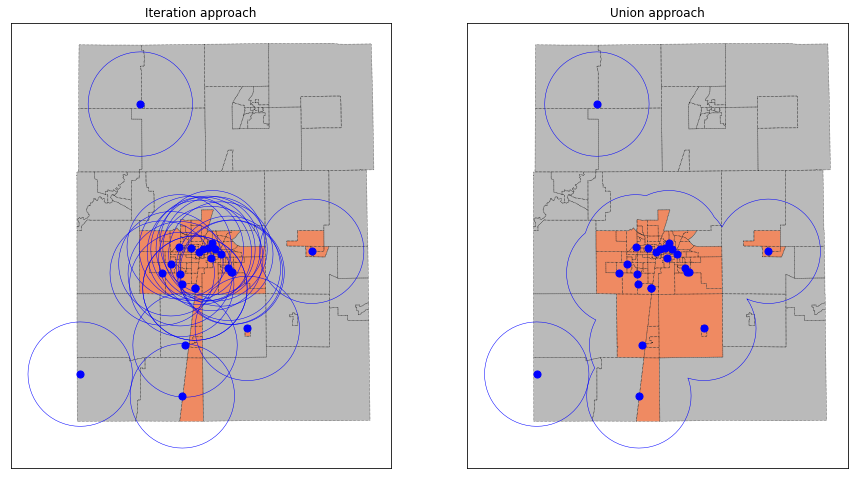

In [27]:
# Plot two layers
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Iteration approach
hc_buffer.boundary.plot(ax=axes[0], color='blue', lw=0.5, zorder=2)
y_buffer.plot(ax=axes[0], color='#ef8a62', zorder=1)
n_buffer.plot(ax=axes[0], color='#bababa', zorder=1)

## Decoration purpose
hc.plot(ax=axes[0], markersize=50, color='blue', zorder=2)
cbg.boundary.plot(ax=axes[0], linestyle='dotted', lw=0.5, color='black', zorder=1)
axes[0].set_title('Iteration approach')
axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)

# Union Approach
hc_buffer_union.boundary.plot(ax=axes[1], color='blue', lw=0.5, zorder=2)
y_buffer_1.plot(ax=axes[1], color='#ef8a62', zorder=1)
n_buffer_1.plot(ax=axes[1], color='#bababa', zorder=1)

## Decoration purpose
hc.plot(ax=axes[1], markersize=50, color='blue', zorder=2)
cbg.boundary.plot(ax=axes[1], linestyle='dotted', lw=0.5, color='black', zorder=1)
axes[1].set_title('Union approach')
axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)

plt.show()

## 3. Euclidean distance based on OD (Origin-Destination) Matrix

The buffer analysis has some issues of underestimate/overestimate the access. For example, the upper left buffer does not have any census block group selected. <br>
To increase the accuracy of analysis, we can measure the distance between every census block group and healthcare resource. Here, we take advantage of the `.distance()` method of `shapely`. 


In [28]:
hc.head()

,NAME,TYPE,geometry
0,THE CARLE FOUNDATION HOSPITAL,Hospital,POINT (310091.878 383002.829)
1,THE PAVILION FOUNDATION,Hospital,POINT (306461.377 383072.805)
2,OSF HEALTHCARE SYSTEM HEART OF MARY MEDICAL CE...,Hospital,POINT (309055.291 383104.709)
3,URBANA FIRE RESCUE SERVICES - MAIN STATION,EMS,POINT (310981.581 382221.278)
4,SAVOY FIRE DEPARTMENT,EMS,POINT (307012.101 376990.985)


In [29]:
cbg.head()

,STATEFP,COUNTYFP,GEOID,geometry
0,17,019,170190008004,"POLYGON ((306407.568 387381.633, 306409.506 38..."
1,17,019,170190109021,"POLYGON ((301663.744 375331.378, 301664.492 37..."
2,17,019,170190014003,"POLYGON ((307179.741 377349.506, 307179.910 37..."
3,17,019,170190008003,"POLYGON ((304790.796 387513.235, 304795.054 38..."
4,17,019,170190109023,"POLYGON ((288952.382 366354.051, 289005.181 36..."


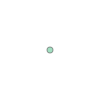

In [30]:
hc.at[0, 'geometry']

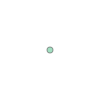

In [31]:
cbg.at[0, 'geometry'].centroid

In [32]:
hc.at[0, 'geometry'].distance(cbg.at[0, 'geometry'].centroid)

4581.967395749192

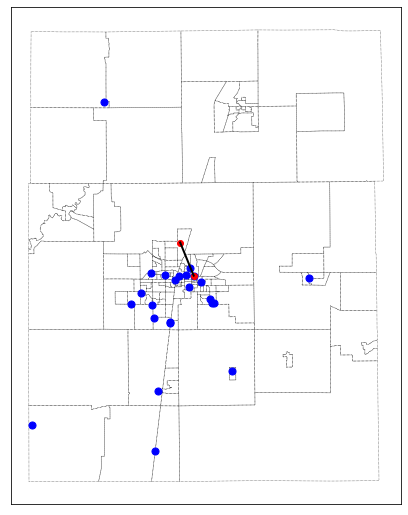

In [33]:
# Plot two layers
fig, ax = plt.subplots(figsize=(7, 10))

# Create points of origin and desitnation and connect them. 
ori = hc.at[0, 'geometry']
dest = cbg.at[0, 'geometry'].centroid

plt.plot(ori.x, ori.y, 'ro')
plt.plot(dest.x, dest.y, 'ro')
plt.plot([ori.x, dest.x], [ori.y, dest.y], color='black', lw=2)

# Decoration
hc.plot(ax=ax, markersize=50, color='blue', zorder=2)
cbg.boundary.plot(ax=ax, linestyle='dotted', lw=0.5, color='black', zorder=1)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

In [34]:
# Calculate euclidean distance between every healthcare and census block group
within_eucli = []

for idx_h, row_h in hc.iterrows():
    for idx_c, row_c in cbg.iterrows():
        
        temp_dist = row_h.geometry.distance(row_c.geometry.centroid)
        print(f'From HC {idx_h} to CBG {idx_c}, Distance: {round(temp_dist)} m' )
        
        if temp_dist < dist:
            within_eucli.append(row_c['GEOID'])


From HC 0 to CBG 0, Distance: 4582 m
From HC 0 to CBG 1, Distance: 13041 m
From HC 0 to CBG 2, Distance: 4885 m
From HC 0 to CBG 3, Distance: 5541 m
From HC 0 to CBG 4, Distance: 26945 m
From HC 0 to CBG 5, Distance: 18883 m
From HC 0 to CBG 6, Distance: 17653 m
From HC 0 to CBG 7, Distance: 6759 m
From HC 0 to CBG 8, Distance: 12771 m
From HC 0 to CBG 9, Distance: 9602 m
From HC 0 to CBG 10, Distance: 9946 m
From HC 0 to CBG 11, Distance: 14365 m
From HC 0 to CBG 12, Distance: 4757 m
From HC 0 to CBG 13, Distance: 12120 m
From HC 0 to CBG 14, Distance: 14416 m
From HC 0 to CBG 15, Distance: 7361 m
From HC 0 to CBG 16, Distance: 5646 m
From HC 0 to CBG 17, Distance: 938 m
From HC 0 to CBG 18, Distance: 1529 m
From HC 0 to CBG 19, Distance: 21152 m
From HC 0 to CBG 20, Distance: 3123 m
From HC 0 to CBG 21, Distance: 14604 m
From HC 0 to CBG 22, Distance: 2922 m
From HC 0 to CBG 23, Distance: 13283 m
From HC 0 to CBG 24, Distance: 21230 m
From HC 0 to CBG 25, Distance: 15699 m
From HC 0 

From HC 3 to CBG 101, Distance: 6217 m
From HC 3 to CBG 102, Distance: 2990 m
From HC 3 to CBG 103, Distance: 31995 m
From HC 3 to CBG 104, Distance: 2450 m
From HC 3 to CBG 105, Distance: 2278 m
From HC 3 to CBG 106, Distance: 17041 m
From HC 3 to CBG 107, Distance: 22443 m
From HC 3 to CBG 108, Distance: 2760 m
From HC 3 to CBG 109, Distance: 4869 m
From HC 3 to CBG 110, Distance: 701 m
From HC 3 to CBG 111, Distance: 22526 m
From HC 3 to CBG 112, Distance: 2962 m
From HC 3 to CBG 113, Distance: 2901 m
From HC 3 to CBG 114, Distance: 2291 m
From HC 3 to CBG 115, Distance: 3098 m
From HC 3 to CBG 116, Distance: 3614 m
From HC 3 to CBG 117, Distance: 4175 m
From HC 3 to CBG 118, Distance: 4093 m
From HC 3 to CBG 119, Distance: 3622 m
From HC 3 to CBG 120, Distance: 4001 m
From HC 3 to CBG 121, Distance: 4411 m
From HC 3 to CBG 122, Distance: 5377 m
From HC 3 to CBG 123, Distance: 7380 m
From HC 3 to CBG 124, Distance: 5387 m
From HC 3 to CBG 125, Distance: 8157 m
From HC 3 to CBG 126, 

From HC 7 to CBG 63, Distance: 31794 m
From HC 7 to CBG 64, Distance: 29406 m
From HC 7 to CBG 65, Distance: 15504 m
From HC 7 to CBG 66, Distance: 14851 m
From HC 7 to CBG 67, Distance: 13260 m
From HC 7 to CBG 68, Distance: 11465 m
From HC 7 to CBG 69, Distance: 16377 m
From HC 7 to CBG 70, Distance: 9551 m
From HC 7 to CBG 71, Distance: 6898 m
From HC 7 to CBG 72, Distance: 11726 m
From HC 7 to CBG 73, Distance: 35769 m
From HC 7 to CBG 74, Distance: 12978 m
From HC 7 to CBG 75, Distance: 15282 m
From HC 7 to CBG 76, Distance: 33588 m
From HC 7 to CBG 77, Distance: 32838 m
From HC 7 to CBG 78, Distance: 25598 m
From HC 7 to CBG 79, Distance: 13938 m
From HC 7 to CBG 80, Distance: 12611 m
From HC 7 to CBG 81, Distance: 12561 m
From HC 7 to CBG 82, Distance: 11348 m
From HC 7 to CBG 83, Distance: 11384 m
From HC 7 to CBG 84, Distance: 9256 m
From HC 7 to CBG 85, Distance: 34217 m
From HC 7 to CBG 86, Distance: 35467 m
From HC 7 to CBG 87, Distance: 33662 m
From HC 7 to CBG 88, Distanc

From HC 11 to CBG 50, Distance: 20879 m
From HC 11 to CBG 51, Distance: 16764 m
From HC 11 to CBG 52, Distance: 17921 m
From HC 11 to CBG 53, Distance: 23316 m
From HC 11 to CBG 54, Distance: 32857 m
From HC 11 to CBG 55, Distance: 14850 m
From HC 11 to CBG 56, Distance: 30026 m
From HC 11 to CBG 57, Distance: 13894 m
From HC 11 to CBG 58, Distance: 20863 m
From HC 11 to CBG 59, Distance: 24762 m
From HC 11 to CBG 60, Distance: 16408 m
From HC 11 to CBG 61, Distance: 23729 m
From HC 11 to CBG 62, Distance: 12367 m
From HC 11 to CBG 63, Distance: 22389 m
From HC 11 to CBG 64, Distance: 19924 m
From HC 11 to CBG 65, Distance: 18996 m
From HC 11 to CBG 66, Distance: 19284 m
From HC 11 to CBG 67, Distance: 21772 m
From HC 11 to CBG 68, Distance: 11696 m
From HC 11 to CBG 69, Distance: 9044 m
From HC 11 to CBG 70, Distance: 13620 m
From HC 11 to CBG 71, Distance: 12708 m
From HC 11 to CBG 72, Distance: 14802 m
From HC 11 to CBG 73, Distance: 25142 m
From HC 11 to CBG 74, Distance: 12716 m
F

From HC 15 to CBG 83, Distance: 2423 m
From HC 15 to CBG 84, Distance: 4623 m
From HC 15 to CBG 85, Distance: 24329 m
From HC 15 to CBG 86, Distance: 24820 m
From HC 15 to CBG 87, Distance: 23562 m
From HC 15 to CBG 88, Distance: 28451 m
From HC 15 to CBG 89, Distance: 14523 m
From HC 15 to CBG 90, Distance: 18327 m
From HC 15 to CBG 91, Distance: 29261 m
From HC 15 to CBG 92, Distance: 27231 m
From HC 15 to CBG 93, Distance: 21950 m
From HC 15 to CBG 94, Distance: 17862 m
From HC 15 to CBG 95, Distance: 1552 m
From HC 15 to CBG 96, Distance: 17796 m
From HC 15 to CBG 97, Distance: 3717 m
From HC 15 to CBG 98, Distance: 2590 m
From HC 15 to CBG 99, Distance: 731 m
From HC 15 to CBG 100, Distance: 24804 m
From HC 15 to CBG 101, Distance: 3382 m
From HC 15 to CBG 102, Distance: 343 m
From HC 15 to CBG 103, Distance: 30166 m
From HC 15 to CBG 104, Distance: 4777 m
From HC 15 to CBG 105, Distance: 1024 m
From HC 15 to CBG 106, Distance: 14084 m
From HC 15 to CBG 107, Distance: 24467 m
From

From HC 19 to CBG 47, Distance: 5798 m
From HC 19 to CBG 48, Distance: 5907 m
From HC 19 to CBG 49, Distance: 5228 m
From HC 19 to CBG 50, Distance: 1763 m
From HC 19 to CBG 51, Distance: 4958 m
From HC 19 to CBG 52, Distance: 11258 m
From HC 19 to CBG 53, Distance: 34790 m
From HC 19 to CBG 54, Distance: 15828 m
From HC 19 to CBG 55, Distance: 7655 m
From HC 19 to CBG 56, Distance: 13701 m
From HC 19 to CBG 57, Distance: 9253 m
From HC 19 to CBG 58, Distance: 1329 m
From HC 19 to CBG 59, Distance: 3315 m
From HC 19 to CBG 60, Distance: 5555 m
From HC 19 to CBG 61, Distance: 24938 m
From HC 19 to CBG 62, Distance: 10486 m
From HC 19 to CBG 63, Distance: 24720 m
From HC 19 to CBG 64, Distance: 23016 m
From HC 19 to CBG 65, Distance: 3710 m
From HC 19 to CBG 66, Distance: 2797 m
From HC 19 to CBG 67, Distance: 3043 m
From HC 19 to CBG 68, Distance: 9999 m
From HC 19 to CBG 69, Distance: 27817 m
From HC 19 to CBG 70, Distance: 8334 m
From HC 19 to CBG 71, Distance: 10471 m
From HC 19 to C

From HC 23 to CBG 0, Distance: 10245 m
From HC 23 to CBG 1, Distance: 6211 m
From HC 23 to CBG 2, Distance: 3013 m
From HC 23 to CBG 3, Distance: 8949 m
From HC 23 to CBG 4, Distance: 19547 m
From HC 23 to CBG 5, Distance: 11554 m
From HC 23 to CBG 6, Distance: 16047 m
From HC 23 to CBG 7, Distance: 11090 m
From HC 23 to CBG 8, Distance: 19346 m
From HC 23 to CBG 9, Distance: 7824 m
From HC 23 to CBG 10, Distance: 4808 m
From HC 23 to CBG 11, Distance: 20093 m
From HC 23 to CBG 12, Distance: 6446 m
From HC 23 to CBG 13, Distance: 10213 m
From HC 23 to CBG 14, Distance: 20648 m
From HC 23 to CBG 15, Distance: 1226 m
From HC 23 to CBG 16, Distance: 8342 m
From HC 23 to CBG 17, Distance: 6523 m
From HC 23 to CBG 18, Distance: 8975 m
From HC 23 to CBG 19, Distance: 27848 m
From HC 23 to CBG 20, Distance: 6274 m
From HC 23 to CBG 21, Distance: 9216 m
From HC 23 to CBG 22, Distance: 8426 m
From HC 23 to CBG 23, Distance: 7805 m
From HC 23 to CBG 24, Distance: 26452 m
From HC 23 to CBG 25, Di

In [35]:
set(within_eucli)

{'170190002001',
 '170190002002',
 '170190003011',
 '170190003012',
 '170190003013',
 '170190003021',
 '170190003022',
 '170190003023',
 '170190004011',
 '170190004012',
 '170190004021',
 '170190004022',
 '170190005001',
 '170190005002',
 '170190005003',
 '170190005004',
 '170190007001',
 '170190007002',
 '170190007003',
 '170190008001',
 '170190008002',
 '170190008003',
 '170190008004',
 '170190009011',
 '170190009012',
 '170190009013',
 '170190009014',
 '170190009021',
 '170190009022',
 '170190009023',
 '170190010001',
 '170190010002',
 '170190010003',
 '170190010004',
 '170190010005',
 '170190011001',
 '170190011002',
 '170190011003',
 '170190012011',
 '170190012012',
 '170190012013',
 '170190012014',
 '170190012015',
 '170190012031',
 '170190012032',
 '170190012033',
 '170190012041',
 '170190012051',
 '170190012052',
 '170190012061',
 '170190013011',
 '170190013012',
 '170190013013',
 '170190013014',
 '170190013015',
 '170190013021',
 '170190013022',
 '170190013023',
 '170190014001

In [36]:
# Select census block groups within the distance 
y_eucli = cbg.loc[cbg['GEOID'].isin(set(within_eucli))]
n_eucli = cbg.loc[~cbg['GEOID'].isin(set(within_eucli))]

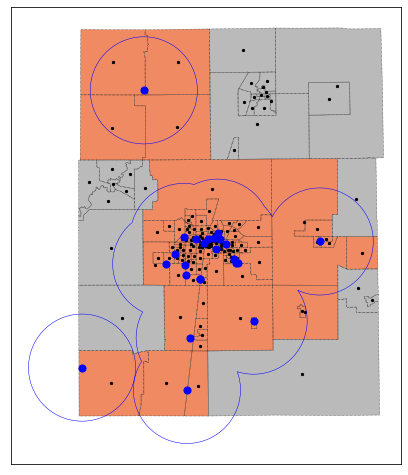

In [37]:
# Plot Eluclidean distance result
fig, ax = plt.subplots(figsize=(7, 10))

hc_buffer_union.boundary.plot(ax=ax, color='blue', lw=0.5, zorder=2)
y_eucli.plot(ax=ax, color='#ef8a62', zorder=1)
n_eucli.plot(ax=ax, color='#bababa', zorder=1)

# Decoration
hc.plot(ax=ax, markersize=50, color='blue', zorder=2)
cbg.centroid.plot(ax=ax, markersize=5, color='black')  # Centroids of Census Block Groups
cbg.boundary.plot(ax=ax, linestyle='dotted', lw=0.5, color='black', zorder=1)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

## 4. Manhattan Distance based on OD Matrix

Given the fact that people actually travel through the road network, consideration of manhattan distance would provide more accurate information. <br>
For this purpose, we will employ two packages, `osmnx` and `networkx`. 
* <a href=https://osmnx.readthedocs.io/en/stable/>`osmnx`</a> is a Python package to retrieve, model, analyze, and visualize street networks from OpenStreetMap. It inherits most of configuration of `networkx`. Users can download and model walkable, drivable, or bikeable urban networks with a single line of Python code, and then easily analyze and visualize them. 
* <a href=https://networkx.org/>`NetworkX`</a> is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.



In [38]:
# Import necessary packages
import osmnx as ox
import networkx as nx
from tqdm import tqdm

### 4.1. Data preprocessing

We can import road network from anywhere around the world with <a href=https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.graph.graph_from_place>`ox.graph_from_place()`</a>. The return variable has the type of `networkx`. 

In [39]:
G = ox.graph_from_place('Champaign County, IL, USA', network_type='drive', simplify=True)
G

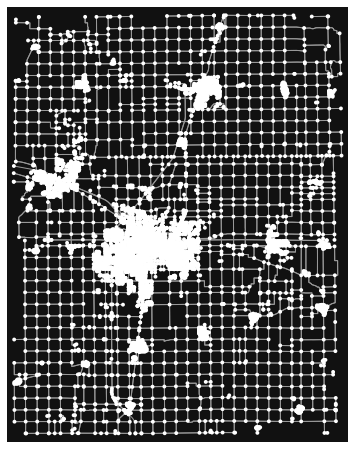

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [40]:
ox.plot_graph(G)

We need to match CRS to measure the distance, appropriately; therefore, we project the graph to epsg 26971.

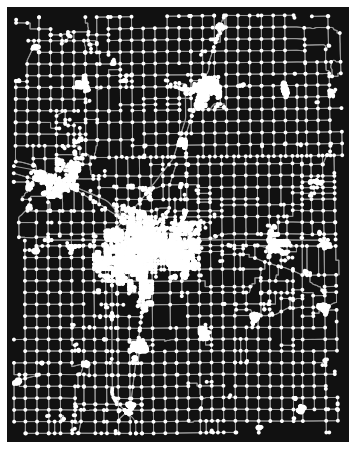

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [41]:
G = ox.projection.project_graph(G, to_crs='epsg:26971')
ox.plot_graph(G)

Next step is to find the nearest osm element from `hc` and `cbg` for running network analysis on the OSM network. 

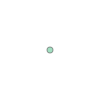

In [42]:
hc.at[0, 'geometry'] # Geometry of the Carle Foundation Hospital

In [43]:
# This function returns the OSM id of the node
ox.distance.nearest_nodes(G=G, 
                          X=hc.at[0, 'geometry'].x, 
                          Y=hc.at[0, 'geometry'].y,
#                           return_dist=True
                         )

1557362911

In [44]:
# This function helps you to find the nearest OSM node from a given GeoDataFrame
# If geom type is point, it will take it without modification, but 
# IF geom type is polygon or multipolygon, it will take its centroid to calculate the nearest element. 

def find_nearest_osm(network, gdf):
    for idx, row in tqdm(gdf.iterrows(), total=gdf.shape[0]):
        if row.geometry.geom_type == 'Point':
            nearest_osm = ox.distance.nearest_nodes(network, 
                                                    X=row.geometry.x, 
                                                    Y=row.geometry.y
                                                   )
        elif row.geometry.geom_type == 'Polygon' or row.geometry.geom_type == 'MultiPolygon':
            nearest_osm = ox.distance.nearest_nodes(network, 
                                        X=row.geometry.centroid.x, 
                                        Y=row.geometry.centroid.y
                                       )
        else:
            print(row.geometry.geom_type)
            continue

        gdf.at[idx, 'nearest_osm'] = nearest_osm

    return gdf

In [45]:
hc = find_nearest_osm(G, hc)
cbg = find_nearest_osm(G, cbg)

100%|██████████| 158/158 [00:07<00:00, 22.04it/s]


In [46]:
hc.head()

,NAME,TYPE,geometry,nearest_osm
0,THE CARLE FOUNDATION HOSPITAL,Hospital,POINT (310091.878 383002.829),1.557363e+09
1,THE PAVILION FOUNDATION,Hospital,POINT (306461.377 383072.805),3.815497e+07
2,OSF HEALTHCARE SYSTEM HEART OF MARY MEDICAL CE...,Hospital,POINT (309055.291 383104.709),3.804887e+07
3,URBANA FIRE RESCUE SERVICES - MAIN STATION,EMS,POINT (310981.581 382221.278),3.409333e+09
4,SAVOY FIRE DEPARTMENT,EMS,POINT (307012.101 376990.985),3.815052e+07


In [47]:
cbg.head()

,STATEFP,COUNTYFP,GEOID,geometry,nearest_osm
0,17,019,170190008004,"POLYGON ((306407.568 387381.633, 306409.506 38...",38087703.0
1,17,019,170190109021,"POLYGON ((301663.744 375331.378, 301664.492 37...",37972605.0
2,17,019,170190014003,"POLYGON ((307179.741 377349.506, 307179.910 37...",37965596.0
3,17,019,170190008003,"POLYGON ((304790.796 387513.235, 304795.054 38...",38079683.0
4,17,019,170190109023,"POLYGON ((288952.382 366354.051, 289005.181 36...",38117916.0


It is also possible to convert the OSM road network to GeoPandas GeoDataFrame with `ox.graph_to_gdfs()`. 

In [48]:
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True)

In [49]:
edges.head()

osmid                   name      highway  oneway  \
u        v        key                                                        
37945221 38074407 0    5337600       Briarcliff Drive  residential   False   
         38073482 0    5344674             Mark Place  residential   False   
         37945226 0    5324513  West Briarcliff Drive  residential   False   
38074407 37945221 0    5337600       Briarcliff Drive  residential   False   
         38074404 0    5337600       Briarcliff Drive  residential   False   

                        length  \
u        v        key            
37945221 38074407 0     50.543   
         38073482 0     96.407   
         37945226 0    244.234   
38074407 37945221 0     50.543   
         38074404 0    106.283   

                                                                geometry  \
u        v        key                                                      
37945221 38074407 0    LINESTRING (324604.563 381949.032, 324655.232 ...   
         38073482 0    LINESTRING (324604.563 381949.032, 324604.364 ...   
         37945226 0    LINESTRING (324604.563 381949.032, 324438.736 ...   
38074407 37945221 0    LINESTRING (324655.232 381949.086, 324604.563 ...   
         38074404 0    LINESTRING (324655.232 381949.086, 324761.780 ...   

                      lanes  ref bridge maxspeed junction access tunnel  
u        v        key                                                    
37945221 38074407 0     NaN  NaN    NaN      NaN      NaN    NaN    NaN  
         38073482 0     NaN  NaN    NaN      NaN      NaN    NaN    NaN  
         37945226 0     NaN  NaN    NaN      NaN      NaN    NaN    NaN  
38074407 37945221 0     NaN  NaN    NaN      NaN      NaN    NaN    NaN  
         38074404 0     NaN  NaN    NaN      NaN      NaN    NaN    NaN

In [50]:
nodes.head()

,y,x,street_count,lon,lat,highway,ref,geometry
osmid,,,,,,,,
37945221,381949.032111,324604.562954,3,-88.044744,40.107252,NaN,NaN,POINT (324604.563 381949.032)
38074407,381949.085639,324655.231946,3,-88.044150,40.107251,NaN,NaN,POINT (324655.232 381949.086)
38073482,381852.764054,324604.363937,3,-88.044750,40.106385,NaN,NaN,POINT (324604.364 381852.764)
37945226,381950.029382,324359.731304,3,-88.047616,40.107268,NaN,NaN,POINT (324359.731 381950.029)
37975481,382003.804858,324360.104103,3,-88.047609,40.107752,NaN,NaN,POINT (324360.104 382003.805)


### 4.2. Calculate the shortest path between two locations

We can calculate shortest path between two locations and produce two different results.
* <a href=https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.shortest_path.html>nx.shortest_path()</a>: Compute shortest paths in the graph.
* <a href=https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.shortest_path_length.html>nx.shortest_path_length()</a>: Compute shortest path lengths in the graph.

In [51]:
hc.loc[0]

NAME                         THE CARLE FOUNDATION HOSPITAL
TYPE                                              Hospital
geometry       POINT (310091.87816100905 383002.829220243)
nearest_osm                                   1557362911.0
Name: 0, dtype: object

In [52]:
hc.loc[1]

NAME                               THE PAVILION FOUNDATION
TYPE                                              Hospital
geometry       POINT (306461.3772480399 383072.8050260019)
nearest_osm                                     38154973.0
Name: 1, dtype: object

In [53]:
# Returns the node ids of the shortest path
routes = nx.shortest_path(G=G, 
                          source=hc.loc[0, 'nearest_osm'], 
                          target=hc.loc[1, 'nearest_osm'], 
                          weight='length',
                          method='dijkstra'
                         )
routes

[1557362911.0,
 38020611,
 38002584,
 38035904,
 6746999971,
 1781110906,
 38035919,
 1507899578,
 2058701942,
 1905962826,
 38035929,
 37985146,
 6563450916,
 37974740,
 38046725,
 37982544,
 37982901,
 37979004,
 38022920,
 38046741,
 38052211,
 38052209,
 38052208,
 1520525862,
 38135457,
 38026275,
 37988806,
 37970460,
 37987097,
 38014203,
 38135488,
 38154973.0]

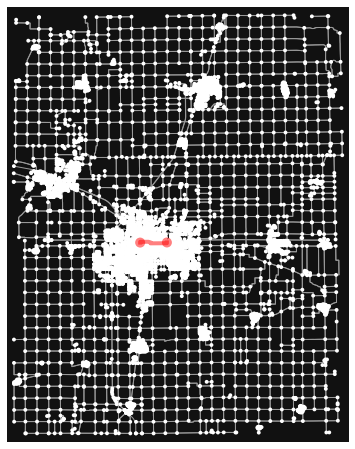

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [54]:
ox.plot.plot_graph_route(G, routes)

In [55]:
# Returns the length of the shortest path
nx.shortest_path_length(G=G, 
                        source=hc.loc[0, 'nearest_osm'], 
                        target=hc.loc[1, 'nearest_osm'], 
                        weight='length',
                        method='dijkstra'
                       )

4090.404

Verify distance on Google Maps. 

https://www.google.com/maps/dir/Carle+Foundation+Hospital,+West+Park+Street,+Urbana,+IL/The+Pavilion+Foundation,+809+W+Church+St,+Champaign,+IL+61820/@40.1199771,-88.2449266,15z/data=!3m1!4b1!4m14!4m13!1m5!1m1!1s0x880cd7719b423a01:0x1cbc0832642e6bd9!2m2!1d-88.2155548!2d40.1169714!1m5!1m1!1s0x880cd0ba1673d039:0x1222076f6d85d29c!2m2!1d-88.2576659!2d40.1177169!3e0

In [56]:
# Calculate Manhattan distance between every healthcare and census block group
within_manh = []

for idx_h, row_h in tqdm(hc.iterrows(), total=hc.shape[0]):
    for idx_c, row_c in cbg.iterrows():
        
        temp_dist = nx.shortest_path_length(G=G, 
                                            source=row_h['nearest_osm'], 
                                            target=row_c['nearest_osm'], 
                                            weight='length',
                                            method='dijkstra'
                                           )
#         print(f'From HC {idx_h} to CBG {idx_c}, Distance: {round(temp_dist)} m' )
        
        if temp_dist < dist:
            within_manh.append(row_c['GEOID'])


100%|██████████| 24/24 [01:04<00:00,  2.68s/it]


In [57]:
# Select census block groups within the distance 
y_manh = cbg.loc[cbg['GEOID'].isin(set(within_manh))]
n_manh = cbg.loc[~cbg['GEOID'].isin(set(within_manh))]

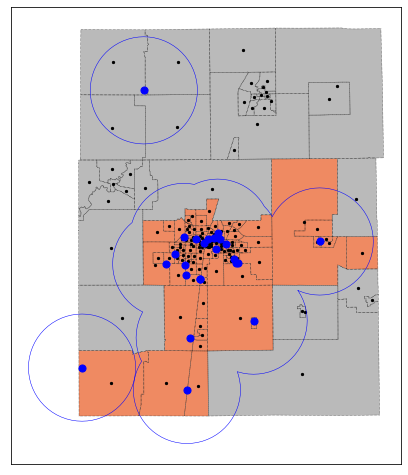

In [58]:
# Plot Manhattan distance result
fig, ax = plt.subplots(figsize=(7, 10))

hc_buffer_union.boundary.plot(ax=ax, color='blue', lw=0.5, zorder=2)
y_manh.plot(ax=ax, color='#ef8a62', zorder=1)
n_manh.plot(ax=ax, color='#bababa', zorder=1)

# Decoration
hc.plot(ax=ax, markersize=50, color='blue', zorder=2)
cbg.centroid.plot(ax=ax, markersize=5, color='black')  # Centroids of Census Block Groups
cbg.boundary.plot(ax=ax, linestyle='dotted', lw=0.5, color='black', zorder=1)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

## 5. Compare the results

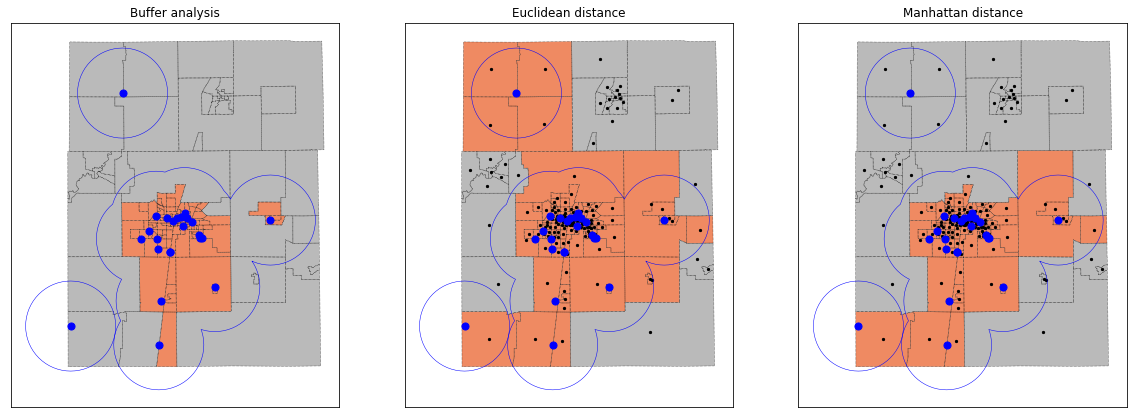

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# First approach: Buffer analysis
hc_buffer_union.boundary.plot(ax=axes[0], color='blue', lw=0.5, zorder=2)
y_buffer_1.plot(ax=axes[0], color='#ef8a62', zorder=1)
n_buffer_1.plot(ax=axes[0], color='#bababa', zorder=1)

## Decoration purpose
hc.plot(ax=axes[0], markersize=50, color='blue', zorder=2)
cbg.boundary.plot(ax=axes[0], linestyle='dotted', lw=0.5, color='black', zorder=1)
axes[0].set_title('Buffer analysis')
axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)

# Second approach: Euclidean distance OD matrix
hc_buffer_union.boundary.plot(ax=axes[1], color='blue', lw=0.5, zorder=2)
y_eucli.plot(ax=axes[1], color='#ef8a62', zorder=1)
n_eucli.plot(ax=axes[1], color='#bababa', zorder=1)

# Decoration
hc.plot(ax=axes[1], markersize=50, color='blue', zorder=2)
cbg.centroid.plot(ax=axes[1], markersize=5, color='black')  # Centroids of Census Block Groups
cbg.boundary.plot(ax=axes[1], linestyle='dotted', lw=0.5, color='black', zorder=1)
axes[1].set_title('Euclidean distance')
axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)

# Third approach: Manhattan distance OD matrix
hc_buffer_union.boundary.plot(ax=axes[2], color='blue', lw=0.5, zorder=2)
y_manh.plot(ax=axes[2], color='#ef8a62', zorder=1)
n_manh.plot(ax=axes[2], color='#bababa', zorder=1)

# Decoration
hc.plot(ax=axes[2], markersize=50, color='blue', zorder=2)
cbg.centroid.plot(ax=axes[2], markersize=5, color='black')  # Centroids of Census Block Groups
cbg.boundary.plot(ax=axes[2], linestyle='dotted', lw=0.5, color='black', zorder=1)
axes[2].set_title('Manhattan distance')
axes[2].get_xaxis().set_visible(False)
axes[2].get_yaxis().set_visible(False)

plt.show()

## 6. The most efficient and accurate way: Manhattan distance with Convex Hull

One of the caveats calculating the OD matrix of Manhattan distance is the computational intensity. It is slow. <br>
One workaround is to calculate the list of nodes that is accessible from healthcare resources and create their convex hull. It will provide a higher accuracy, but the computational speed will be similar to the buffer analysis. 

* <a href=https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.weighted.single_source_dijkstra_path_length.html>nx.single_source_dijkstra_path_length</a>: Find shortest weighted path lengths in G from a source node.

In [60]:
# This returns the dictionary that has OSM node as its key and the distance as value.
temp_nodes = nx.single_source_dijkstra_path_length(G, hc.loc[0, 'nearest_osm'], dist, weight='length')
temp_nodes

{1557362911.0: 0,
 1557362896: 46.535,
 38020611: 103.16900000000001,
 38023851: 136.74699999999999,
 38002584: 218.995,
 38023850: 238.121,
 37959527: 300.326,
 38002576: 324.48199999999997,
 38020614: 330.74699999999996,
 1557362906: 359.795,
 38035904: 362.207,
 37972799: 382.13,
 38013671: 403.113,
 2702125263: 440.43199999999996,
 37960887: 451.179,
 38077308: 463.533,
 38048825: 464.60799999999995,
 6746999971: 474.203,
 2023743957: 482.35999999999996,
 37972793: 484.241,
 1781110906: 529.799,
 6796076833: 535.346,
 6746999974: 541.121,
 2702125254: 542.3679999999999,
 38035889: 554.163,
 7353102911: 571.387,
 2802542818: 573.837,
 38035887: 585.356,
 38048805: 586.212,
 38002569: 589.328,
 2023743955: 591.715,
 6532785078: 611.212,
 1917619278: 628.279,
 38002562: 630.1419999999999,
 6796076832: 635.376,
 7353102905: 637.174,
 6796076850: 637.43,
 2702125262: 638.143,
 6783599606: 638.995,
 2702125261: 640.813,
 38035919: 643.59,
 6783599609: 648.389,
 38020591: 648.732,
 678356

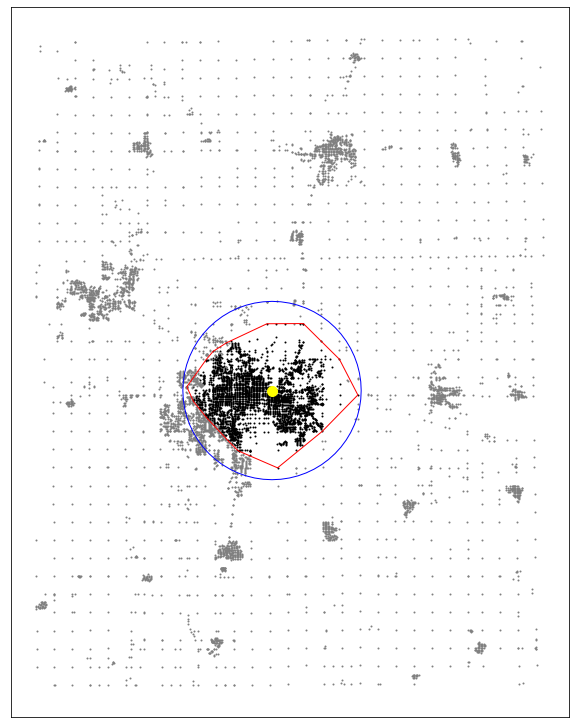

In [61]:
fig, ax = plt.subplots(figsize=(10, 15))

# Select nodes within threshold distance
nodes.loc[nodes.index.isin(temp_nodes.keys())].plot(ax=ax, color='black', markersize=1)
nodes.loc[~nodes.index.isin(temp_nodes.keys())].plot(ax=ax, color='grey', markersize=1)

gpd.GeoSeries(nodes.loc[nodes.index.isin(temp_nodes.keys()), 'geometry'].unary_union.convex_hull).boundary.plot(ax=ax, color='red', lw=1, zorder=2)
gpd.GeoSeries(hc.loc[0, 'geometry']).buffer(dist).boundary.plot(ax=ax, color='blue', lw=1, zorder=2)
gpd.GeoSeries(hc.loc[0, 'geometry']).plot(ax=ax, color='yellow', markersize=100)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [62]:
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True)
nodes

,y,x,street_count,lon,lat,highway,ref,geometry
osmid,,,,,,,,
37945221,381949.032111,324604.562954,3,-88.044744,40.107252,NaN,NaN,POINT (324604.563 381949.032)
38074407,381949.085639,324655.231946,3,-88.044150,40.107251,NaN,NaN,POINT (324655.232 381949.086)
38073482,381852.764054,324604.363937,3,-88.044750,40.106385,NaN,NaN,POINT (324604.364 381852.764)
37945226,381950.029382,324359.731304,3,-88.047616,40.107268,NaN,NaN,POINT (324359.731 381950.029)
37975481,382003.804858,324360.104103,3,-88.047609,40.107752,NaN,NaN,POINT (324360.104 382003.805)
...,...,...,...,...,...,...,...,...
7026285773,391892.450947,296576.247929,1,-88.373545,40.197158,NaN,NaN,POINT (296576.248 391892.451)
7122360339,390870.656758,295929.041656,1,-88.381139,40.187952,turning_circle,NaN,POINT (295929.042 390870.657)
7130044758,404536.063786,297677.989944,1,-88.360651,40.311030,NaN,NaN,POINT (297677.990 404536.064)


In [63]:
access_nodes = nodes.loc[nodes.index.isin(temp_nodes.keys()), 'geometry']
access_nodes

osmid
37945381      POINT (312180.092 383065.881)
37945481      POINT (312261.415 383066.123)
37945409      POINT (313194.601 383353.825)
38147378      POINT (313194.675 383360.154)
37945412      POINT (313194.151 383318.404)
                          ...              
6133596330    POINT (307844.711 386253.639)
6133596329    POINT (307844.478 386264.654)
6133596363    POINT (307658.532 386251.506)
6133596361    POINT (307658.868 386222.204)
6133596364    POINT (307644.838 386218.837)
Name: geometry, Length: 3446, dtype: geometry

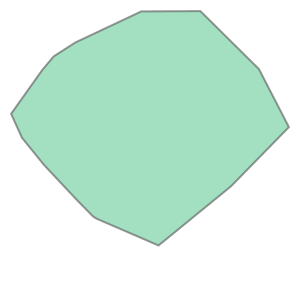

In [64]:
access_nodes.unary_union  # Union every nodes
access_nodes.unary_union.convex_hull # Create convex hull from the unioned nodes

Now we configure a for loop (not nested) to calculate the accessible location at once. 

In [65]:
convex_hulls = gpd.GeoSeries()

for idx, row in tqdm(hc.iterrows(), total=hc.shape[0]):
    temp_nodes = nx.single_source_dijkstra_path_length(G, row['nearest_osm'], dist, weight='length')
    access_nodes = nodes.loc[nodes.index.isin(temp_nodes.keys()), 'geometry']
    access_nodes_ = gpd.GeoSeries(access_nodes.unary_union.convex_hull)
    convex_hulls = convex_hulls.append(access_nodes_, ignore_index=True)
    
convex_hulls

100%|██████████| 24/24 [00:00<00:00, 31.54it/s]


0     POLYGON ((310590.499 376066.840, 307166.363 37...
1     POLYGON ((306917.333 375479.190, 306554.365 37...
2     POLYGON ((308109.064 376043.136, 307026.536 37...
3     POLYGON ((312203.635 375604.075, 310590.499 37...
4     POLYGON ((306140.907 369061.828, 300056.950 37...
5     POLYGON ((288972.528 358213.208, 288952.481 36...
6     POLYGON ((306140.907 369061.828, 300056.950 37...
7     POLYGON ((314708.560 364760.952, 308149.364 37...
8     POLYGON ((308098.978 377658.763, 307133.962 37...
9     POLYGON ((298884.404 398029.438, 294845.326 40...
10    POLYGON ((308295.336 356583.229, 306696.556 35...
11    POLYGON ((325168.047 376084.810, 323276.288 37...
12    POLYGON ((306917.333 375479.190, 306801.396 37...
13    POLYGON ((307661.398 375433.803, 306917.333 37...
14    POLYGON ((302503.950 372454.413, 300882.086 37...
15    POLYGON ((306846.684 374830.530, 306827.481 37...
16    POLYGON ((305151.900 360795.876, 300145.458 36...
17    POLYGON ((310593.889 374431.556, 308109.06

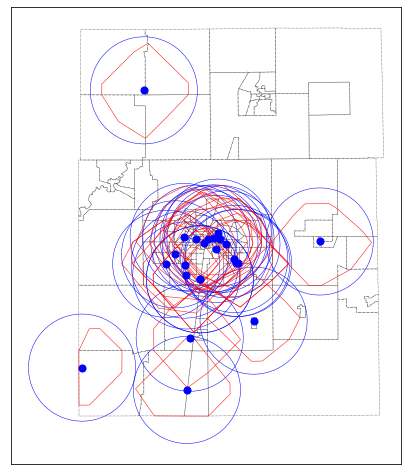

In [66]:
fig, ax = plt.subplots(figsize=(7, 10))

hc_buffer.boundary.plot(ax=ax, color='blue', lw=0.5, zorder=2)
convex_hulls.boundary.plot(ax=ax, color='red', lw=0.5, zorder=2)

## Decoration purpose
hc.plot(ax=ax, markersize=50, color='blue', zorder=2)
cbg.boundary.plot(ax=ax, linestyle='dotted', lw=0.5, color='black', zorder=1)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

We still don't want to have overlaid convex hulls for visualization purposes. Let's use `unary_union` again. 

<AxesSubplot:>

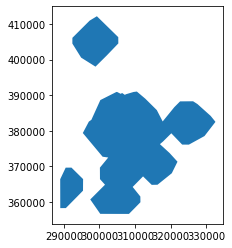

In [67]:
convex_hulls_union = convex_hulls.unary_union
convex_hulls_union = gpd.GeoSeries(convex_hulls_union)
convex_hulls_union.plot()

In [68]:
y_convex_hull = cbg.loc[cbg.geometry.centroid.within(convex_hulls_union[0])]
n_convex_hull = cbg.loc[~cbg.geometry.centroid.within(convex_hulls_union[0])]

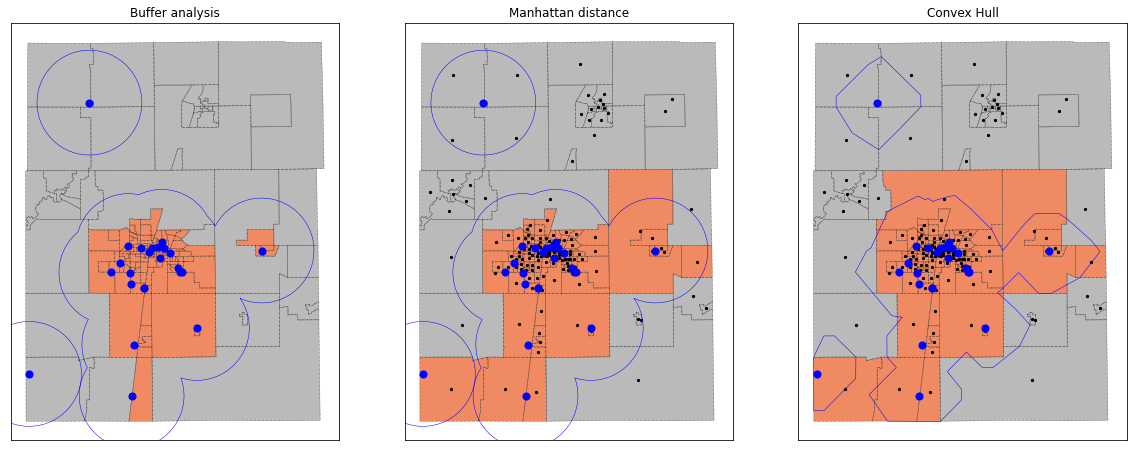

In [69]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# First: Buffer analysis
hc_buffer_union.boundary.plot(ax=axes[0], color='blue', lw=0.5, zorder=2)
y_buffer_1.plot(ax=axes[0], color='#ef8a62', zorder=1)
n_buffer_1.plot(ax=axes[0], color='#bababa', zorder=1)

## Decoration purpose
hc.plot(ax=axes[0], markersize=50, color='blue', zorder=2)
cbg.boundary.plot(ax=axes[0], linestyle='dotted', lw=0.5, color='black', zorder=1)
axes[0].set_title('Buffer analysis')
axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)

# Second: Manhattan distance OD matrix
hc_buffer_union.boundary.plot(ax=axes[1], color='blue', lw=0.5, zorder=2)
y_manh.plot(ax=axes[1], color='#ef8a62', zorder=1)
n_manh.plot(ax=axes[1], color='#bababa', zorder=1)

# Decoration
hc.plot(ax=axes[1], markersize=50, color='blue', zorder=2)
cbg.centroid.plot(ax=axes[1], markersize=5, color='black')  # Centroids of Census Block Groups
cbg.boundary.plot(ax=axes[1], linestyle='dotted', lw=0.5, color='black', zorder=1)
axes[1].set_title('Manhattan distance')
axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)

# Third: Convex Hull
convex_hulls_union.boundary.plot(ax=axes[2], color='blue', lw=0.5, zorder=2)
y_convex_hull.plot(ax=axes[2], color='#ef8a62', zorder=1)
n_convex_hull.plot(ax=axes[2], color='#bababa', zorder=1)

# Decoration
hc.plot(ax=axes[2], markersize=50, color='blue', zorder=2)
cbg.centroid.plot(ax=axes[2], markersize=5, color='black')  # Centroids of Census Block Groups
cbg.boundary.plot(ax=axes[2], linestyle='dotted', lw=0.5, color='black', zorder=1)
axes[2].set_title('Convex Hull')
axes[2].get_xaxis().set_visible(False)
axes[2].get_yaxis().set_visible(False)

axes[0].set_xlim(axes[2].get_xlim())
axes[0].set_ylim(axes[2].get_ylim())

axes[1].set_xlim(axes[2].get_xlim())
axes[1].set_ylim(axes[2].get_ylim())

plt.show()